In [5]:
# 📦 Required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import joblib
import os


In [13]:
import os
import pandas as pd

# 📁 Define file paths
data_dir = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/data/raw"
expr_file = os.path.join(data_dir, "TCGA_LUAD_expr_HGNC.csv")
meta_file = os.path.join(data_dir, "sample_metadata.csv")
# ✅ Load
expr_df = pd.read_csv(expr_file, index_col=0)

# 🧼 Clean sample IDs
expr_df.columns = expr_df.columns.str.replace(r"\.", "-", regex=True).str[:12]

# 🧪 Inspect
print("✅ Expression Matrix Shape:", expr_df.shape)
print(expr_df.iloc[:5, :5])



✅ Expression Matrix Shape: (43772, 600)
          TCGA-44-6147  TCGA-44-6147  TCGA-44-7661  TCGA-05-4396  TCGA-38-4629
symbol                                                                        
5S_rRNA      -4.566271     -4.566271     -4.566271     -4.566271     -4.566271
7SK          -3.086820     -4.423006     -4.566271     -4.566271     -4.566271
A1BG         -0.952503     -2.561994     -2.750826     -4.566271     -2.602032
A1BG-AS1     -0.697511      1.009165     -0.291436     -2.162639      0.056140
A1CF         -0.126053     -3.979406     -3.509782      1.386457     -4.065896


In [15]:
# Check for duplicates
dup_samples = expr_df.columns[expr_df.columns.duplicated()]
print("🧯 Duplicate sample IDs:", dup_samples.tolist())

# Drop or average duplicates — here we drop the second one
expr_df = expr_df.loc[:, ~expr_df.columns.duplicated()]

# Final confirmation
print("✅ Final Expression Matrix Shape (after dedup):", expr_df.shape)


🧯 Duplicate sample IDs: ['TCGA-44-6147', 'TCGA-38-4625', 'TCGA-49-6744', 'TCGA-55-6978', 'TCGA-38-4626', 'TCGA-55-6980', 'TCGA-91-6835', 'TCGA-50-5066', 'TCGA-44-2656', 'TCGA-44-2656', 'TCGA-55-6968', 'TCGA-44-6147', 'TCGA-44-6776', 'TCGA-44-3917', 'TCGA-55-6981', 'TCGA-44-2655', 'TCGA-50-5931', 'TCGA-91-6829', 'TCGA-44-6777', 'TCGA-55-6982', 'TCGA-50-5930', 'TCGA-44-3396', 'TCGA-44-6775', 'TCGA-44-6775', 'TCGA-44-3918', 'TCGA-44-4112', 'TCGA-44-4112', 'TCGA-49-6745', 'TCGA-50-5932', 'TCGA-73-4676', 'TCGA-44-6146', 'TCGA-44-6146', 'TCGA-49-6761', 'TCGA-55-6983', 'TCGA-44-6778', 'TCGA-44-3918', 'TCGA-50-5933', 'TCGA-38-4632', 'TCGA-44-6148', 'TCGA-49-4512', 'TCGA-49-6743', 'TCGA-50-5946', 'TCGA-44-2662', 'TCGA-44-2662', 'TCGA-44-2662', 'TCGA-55-6972', 'TCGA-44-2661', 'TCGA-44-6147', 'TCGA-55-6970', 'TCGA-50-6595', 'TCGA-55-6971', 'TCGA-91-6828', 'TCGA-91-6849', 'TCGA-91-6847', 'TCGA-55-6975', 'TCGA-55-6969', 'TCGA-44-2668', 'TCGA-44-2668', 'TCGA-44-5645', 'TCGA-44-5645', 'TCGA-44-5645',

In [17]:
# ✅ Extract sample types from barcodes
def tcga_sample_type(sample_id):
    try:
        return sample_id.split("-")[3][:2]
    except:
        return "NA"

# 🏷️ Label tumor=1, normal=0
def classify_sample(sample_id):
    code = tcga_sample_type(sample_id)
    if code == "01":
        return 1
    elif code == "11":
        return 0
    else:
        return None

# 🗂️ Build metadata DataFrame
meta_df = pd.DataFrame({
    "sample_id": expr_df.columns,
    "label": [classify_sample(sid) for sid in expr_df.columns]
}).dropna()

# 🔍 Inspect
print("✅ Metadata summary:")
print(meta_df["label"].value_counts())
meta_df.head()


✅ Metadata summary:
Series([], Name: count, dtype: int64)


,sample_id,label


In [19]:
expr_df.columns[:10].tolist()


['TCGA-44-6147',
 'TCGA-44-7661',
 'TCGA-05-4396',
 'TCGA-38-4629',
 'TCGA-55-7724',
 'TCGA-44-6146',
 'TCGA-55-6979',
 'TCGA-91-7771',
 'TCGA-05-4410',
 'TCGA-55-7573']

In [21]:
# ✅ Sample type mapping: '01' = tumor, '11' = normal
def classify_sample(sample_id):
    try:
        sample_type_code = sample_id.split("-")[3][:2]  # e.g., '01' for tumor
        if sample_type_code == "01":
            return 1  # Tumor
        elif sample_type_code == "11":
            return 0  # Normal
        else:
            return None  # Unknown type
    except:
        return None


In [25]:
# Check how many parts exist in each sample ID
[s.split("-") for s in expr_df.columns[:5]]



[['TCGA', '44', '6147'],
 ['TCGA', '44', '7661'],
 ['TCGA', '05', '4396'],
 ['TCGA', '38', '4629'],
 ['TCGA', '55', '7724']]

In [37]:
import os
import requests
import gzip
import shutil

# 📁 Define directories
base_dir = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project"
raw_dir = os.path.join(base_dir, "data", "raw")
os.makedirs(raw_dir, exist_ok=True)

# 📦 Files to download: (filename, URL)
files_to_download = {
    "TCGA-LUAD.GDC_phenotype.tsv.gz": "https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-LUAD.GDC_phenotype.tsv.gz",
    "TCGA_LUAD_expr_HGNC.csv": "https://raw.githubusercontent.com/kartheekpns/TCGA_LUAD_expression/main/TCGA_LUAD_expr_HGNC.csv",
    "sample_metadata.csv": "https://raw.githubusercontent.com/kartheekpns/TCGA_LUAD_expression/main/sample_metadata.csv"
}

# 📥 Function to download a file
def download_file(filename, url):
    dest_path = os.path.join(raw_dir, filename)
    if os.path.exists(dest_path):
        print(f"✅ Already exists: {filename}")
        return dest_path
    print(f"⬇️ Downloading: {filename}")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(dest_path, 'wb') as f:
            f.write(response.content)
        print(f"✅ Downloaded: {filename}")
        return dest_path
    else:
        print(f"❌ Failed to download: {filename} ({response.status_code})")
        return None

# 🗜️ Function to unzip .gz files
def unzip_gz_file(gz_path):
    if not gz_path.endswith(".gz"):
        return
    tsv_path = gz_path.replace(".gz", "")
    if os.path.exists(tsv_path):
        print(f"✅ Already unzipped: {os.path.basename(tsv_path)}")
        return
    print(f"🗜️ Unzipping: {os.path.basename(gz_path)}")
    with gzip.open(gz_path, 'rb') as f_in:
        with open(tsv_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"✅ Unzipped: {os.path.basename(tsv_path)}")

# 🚀 Download all files
for fname, url in files_to_download.items():
    fpath = download_file(fname, url)
    if fpath and fpath.endswith(".gz"):
        unzip_gz_file(fpath)

# 🧾 Summary
print("\n📂 All files saved to:", raw_dir)


⬇️ Downloading: TCGA-LUAD.GDC_phenotype.tsv.gz
❌ Failed to download: TCGA-LUAD.GDC_phenotype.tsv.gz (403)
✅ Already exists: TCGA_LUAD_expr_HGNC.csv
⬇️ Downloading: sample_metadata.csv
❌ Failed to download: sample_metadata.csv (404)

📂 All files saved to: C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project\data\raw


In [39]:
from pathlib import Path

# Set your path
data_dir = Path("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/data/raw")

# List all files
for file in data_dir.glob("*"):
    print(file.name)


desktop.ini
FALSE
GSE43458_expression.csv
GSE43458_metadata.csv
LUAD_PPI_STRING_interactions.csv
TCGA_LUAD_biospecimen.xml
TCGA_LUAD_clinical.csv
TCGA_LUAD_clinical.xml
TCGA_LUAD_CNA.rds
TCGA_LUAD_expr_HGNC.csv
TCGA_LUAD_Methyl.rds
TCGA_LUAD_methylation.csv
TCGA_LUAD_Mutations.maf
TCGA_LUAD_RNA.rds
TCGA_LUAD_RPPA.csv


In [43]:
import pandas as pd

# Path to expression matrix
expr_file = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/data/raw/TCGA_LUAD_expr_HGNC.csv"
output_file = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/data/raw/sample_metadata.csv"

# ✅ Load expression matrix
expr_df = pd.read_csv(expr_file, index_col=0)
print("Expression matrix shape:", expr_df.shape)

# ✅ Extract sample IDs (column names)
sample_ids = expr_df.columns.tolist()

# ✅ Function to extract sample type from TCGA barcode
def get_sample_label(barcode):
    try:
        parts = barcode.split("-")
        if len(parts) >= 4:
            sample_code = parts[3][:2]  # e.g., '01' for Primary Tumor, '11' for Normal Tissue
            return "Tumor" if sample_code in ["01", "02", "06"] else "Normal"
        return "Unknown"
    except:
        return "Unknown"

# ✅ Create metadata dataframe
meta_df = pd.DataFrame({
    "sample_id": sample_ids,
    "label": [get_sample_label(sid) for sid in sample_ids]
})

# ✅ Save metadata to CSV
meta_df.to_csv(output_file, index=False)
print(f"✅ Metadata saved: {output_file}")
print(meta_df['label'].value_counts())


Expression matrix shape: (43772, 600)
✅ Metadata saved: C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/data/raw/sample_metadata.csv
label
Tumor     541
Normal     59
Name: count, dtype: int64


In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

# === Paths ===
expr_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/data/raw/TCGA_LUAD_expr_HGNC.csv"
meta_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/data/raw/sample_metadata.csv"

# === Load Data ===
expr_df = pd.read_csv(expr_path, index_col=0)
meta_df = pd.read_csv(meta_path)

# === Align columns ===
valid_samples = list(set(expr_df.columns).intersection(set(meta_df['sample_id'])))
expr_df = expr_df[valid_samples]
meta_df = meta_df[meta_df['sample_id'].isin(valid_samples)]

# === Ensure same order ===
expr_df = expr_df.loc[:, meta_df['sample_id']]

# === Create features and labels ===
X = expr_df.T.values   # Samples × Features
y = meta_df['label'].values

# === Encode labels ===
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Tumor=1, Normal=0

# === Define outer and inner CV ===
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# === Preview class balance ===
tumor_count = sum(y_encoded)
normal_count = len(y_encoded) - tumor_count
print(f"✅ Expression shape: {X.shape}")
print(f"✅ Labels: Tumor={tumor_count}, Normal={normal_count}")
print(f"✅ Outer CV: 5 folds | Inner CV: 3 folds")

# === Optional: Show fold splits
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y_encoded), start=1):
    print(f"🔄 Outer Fold {fold}: Train={len(train_idx)} | Test={len(test_idx)}")


✅ Expression shape: (600, 43772)
✅ Labels: Tumor=541, Normal=59
✅ Outer CV: 5 folds | Inner CV: 3 folds
🔄 Outer Fold 1: Train=480 | Test=120
🔄 Outer Fold 2: Train=480 | Test=120
🔄 Outer Fold 3: Train=480 | Test=120
🔄 Outer Fold 4: Train=480 | Test=120
🔄 Outer Fold 5: Train=480 | Test=120


In [57]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score, matthews_corrcoef, average_precision_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# === Store final results ===
results = []

# === Start Outer CV ===
for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y_encoded), start=1):
    print(f"\n🔁 Outer Fold {outer_fold}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    # === Inner Bayesian Optimization ===
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "use_label_encoder": False,
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "verbosity": 0
        }

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        aucs = []

        for inner_train_idx, inner_val_idx in skf.split(X_train, y_train):
            dtrain = xgb.DMatrix(X_train[inner_train_idx], label=y_train[inner_train_idx])
            dval = xgb.DMatrix(X_train[inner_val_idx], label=y_train[inner_val_idx])

            booster = xgb.train(params, dtrain, num_boost_round=100, early_stopping_rounds=10,
                                evals=[(dval, "val")], verbose_eval=False)

            preds = booster.predict(dval)
            auc = roc_auc_score(y_train[inner_val_idx], preds)
            aucs.append(auc)

        return np.mean(aucs)

    # ⏳ Run optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, timeout=300)

    print(f"✅ Best inner params: {study.best_params}")

    # === Train final model on full train with best params ===
    best_params = study.best_params
    best_params.update({
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "use_label_encoder": False
    })

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    final_model = xgb.train(best_params, dtrain, num_boost_round=200)

    # === Evaluate on test set ===
    y_pred_prob = final_model.predict(dtest)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)

    auc = roc_auc_score(y_test, y_pred_prob)
    mcc = matthews_corrcoef(y_test, y_pred_bin)
    pr_auc = average_precision_score(y_test, y_pred_prob)

    results.append({
        "fold": outer_fold,
        "auc": auc,
        "mcc": mcc,
        "pr_auc": pr_auc
    })

    print(f"📊 Fold {outer_fold} — AUC: {auc:.4f}, MCC: {mcc:.4f}, PR-AUC: {pr_auc:.4f}")


[I 2025-07-24 02:06:59,476] A new study created in memory with name: no-name-d29f8781-f04c-440b-b5ef-fe57c62119e9



🔁 Outer Fold 1


[I 2025-07-24 02:07:13,365] Trial 0 finished with value: 0.9858217592592592 and parameters: {'max_depth': 3, 'eta': 0.05471547788670348, 'gamma': 4.994890816837993}. Best is trial 0 with value: 0.9858217592592592.
[I 2025-07-24 02:07:28,674] Trial 1 finished with value: 0.9971064814814815 and parameters: {'max_depth': 7, 'eta': 0.22465018287243796, 'gamma': 3.139144612427444}. Best is trial 1 with value: 0.9971064814814815.
[I 2025-07-24 02:07:47,215] Trial 2 finished with value: 0.9861834490740741 and parameters: {'max_depth': 3, 'eta': 0.031923573401928924, 'gamma': 0.586737026058074}. Best is trial 1 with value: 0.9971064814814815.
[I 2025-07-24 02:08:00,522] Trial 3 finished with value: 0.9969618055555557 and parameters: {'max_depth': 10, 'eta': 0.25477679476635423, 'gamma': 3.8595783351042163}. Best is trial 1 with value: 0.9971064814814815.
[I 2025-07-24 02:08:14,823] Trial 4 finished with value: 0.9871238425925927 and parameters: {'max_depth': 8, 'eta': 0.1404215275473951, 'gamm

✅ Best inner params: {'max_depth': 8, 'eta': 0.29754901794309885, 'gamma': 1.9926761353809828}


[I 2025-07-24 02:12:37,390] A new study created in memory with name: no-name-d975a095-79eb-4d55-a4df-77e6bd3bc9dd


📊 Fold 1 — AUC: 1.0000, MCC: 0.8963, PR-AUC: 1.0000

🔁 Outer Fold 2


[I 2025-07-24 02:12:54,750] Trial 0 finished with value: 0.9987659642401022 and parameters: {'max_depth': 9, 'eta': 0.20528798475616777, 'gamma': 3.8940007734204123}. Best is trial 0 with value: 0.9987659642401022.
[I 2025-07-24 02:13:16,027] Trial 1 finished with value: 0.9989106401660282 and parameters: {'max_depth': 5, 'eta': 0.08804173812762851, 'gamma': 4.079361231961084}. Best is trial 1 with value: 0.9989106401660282.
[I 2025-07-24 02:13:42,760] Trial 2 finished with value: 0.9986936262771392 and parameters: {'max_depth': 7, 'eta': 0.02906087583898763, 'gamma': 0.2801501841816789}. Best is trial 1 with value: 0.9989106401660282.
[I 2025-07-24 02:14:02,829] Trial 3 finished with value: 0.9988383022030652 and parameters: {'max_depth': 8, 'eta': 0.04912183819206159, 'gamma': 3.0187197740353398}. Best is trial 1 with value: 0.9989106401660282.
[I 2025-07-24 02:14:18,981] Trial 4 finished with value: 0.9860344827586207 and parameters: {'max_depth': 9, 'eta': 0.013144163043944026, 'ga

✅ Best inner params: {'max_depth': 6, 'eta': 0.15403095368507996, 'gamma': 3.765911282506344}


[I 2025-07-24 02:18:17,164] A new study created in memory with name: no-name-fcc27f6f-ea80-4dc4-93c8-e3c996d5d6ad


📊 Fold 2 — AUC: 0.9985, MCC: 0.9530, PR-AUC: 0.9998

🔁 Outer Fold 3


[I 2025-07-24 02:18:39,369] Trial 0 finished with value: 0.9983999840357599 and parameters: {'max_depth': 9, 'eta': 0.023642451176119468, 'gamma': 1.1108548065348582}. Best is trial 0 with value: 0.9983999840357599.
[I 2025-07-24 02:19:00,875] Trial 1 finished with value: 0.9985532407407408 and parameters: {'max_depth': 10, 'eta': 0.039777244091382405, 'gamma': 0.40476161492427665}. Best is trial 1 with value: 0.9985532407407408.
[I 2025-07-24 02:19:17,300] Trial 2 finished with value: 0.9981020514048531 and parameters: {'max_depth': 10, 'eta': 0.01415137856259343, 'gamma': 4.295689915144269}. Best is trial 1 with value: 0.9985532407407408.
[I 2025-07-24 02:19:40,355] Trial 3 finished with value: 0.9985532407407408 and parameters: {'max_depth': 10, 'eta': 0.02500079859348838, 'gamma': 3.678858157089342}. Best is trial 1 with value: 0.9985532407407408.
[I 2025-07-24 02:19:57,460] Trial 4 finished with value: 0.9983147749042146 and parameters: {'max_depth': 7, 'eta': 0.010479797285111489

✅ Best inner params: {'max_depth': 10, 'eta': 0.18454833381923072, 'gamma': 1.986746291172683}


[I 2025-07-24 02:23:53,653] A new study created in memory with name: no-name-027d7ee7-da85-4601-8a17-c108a4d2290a


📊 Fold 3 — AUC: 0.9961, MCC: 0.9563, PR-AUC: 0.9996

🔁 Outer Fold 4


[I 2025-07-24 02:24:13,666] Trial 0 finished with value: 0.9956499441251597 and parameters: {'max_depth': 5, 'eta': 0.17685831170392305, 'gamma': 2.2778635828439797}. Best is trial 0 with value: 0.9956499441251597.
[I 2025-07-24 02:24:32,704] Trial 1 finished with value: 0.9858248523307792 and parameters: {'max_depth': 10, 'eta': 0.019759580002394316, 'gamma': 0.0669351553728681}. Best is trial 0 with value: 0.9956499441251597.
[I 2025-07-24 02:24:53,491] Trial 2 finished with value: 0.9864035560344829 and parameters: {'max_depth': 10, 'eta': 0.014278913977454812, 'gamma': 2.4751944601501257}. Best is trial 0 with value: 0.9956499441251597.
[I 2025-07-24 02:25:09,762] Trial 3 finished with value: 0.9851609394955302 and parameters: {'max_depth': 9, 'eta': 0.06057118129597696, 'gamma': 1.073144644651326}. Best is trial 0 with value: 0.9956499441251597.
[I 2025-07-24 02:25:27,369] Trial 4 finished with value: 0.9863269276819923 and parameters: {'max_depth': 5, 'eta': 0.02756776300813985, 

✅ Best inner params: {'max_depth': 3, 'eta': 0.13740049442226118, 'gamma': 1.4902810166946}


[I 2025-07-24 04:56:53,593] A new study created in memory with name: no-name-e21222eb-8971-4476-8ecb-b34173348c9a


📊 Fold 4 — AUC: 1.0000, MCC: 1.0000, PR-AUC: 1.0000

🔁 Outer Fold 5


[I 2025-07-24 04:57:09,175] Trial 0 finished with value: 0.9992766203703703 and parameters: {'max_depth': 10, 'eta': 0.09685607112056677, 'gamma': 4.0164895033488115}. Best is trial 0 with value: 0.9992766203703703.
[I 2025-07-24 04:57:25,128] Trial 1 finished with value: 0.9883101851851852 and parameters: {'max_depth': 8, 'eta': 0.013462644415229874, 'gamma': 2.2609912213680055}. Best is trial 0 with value: 0.9992766203703703.
[I 2025-07-24 04:57:40,032] Trial 2 finished with value: 0.9989786877394636 and parameters: {'max_depth': 3, 'eta': 0.053544229159871705, 'gamma': 3.4024764172420676}. Best is trial 0 with value: 0.9992766203703703.
[I 2025-07-24 04:57:57,179] Trial 3 finished with value: 0.9991233636653897 and parameters: {'max_depth': 4, 'eta': 0.025721129896942318, 'gamma': 1.1653551440144272}. Best is trial 0 with value: 0.9992766203703703.
[I 2025-07-24 04:58:13,414] Trial 4 finished with value: 0.9989786877394636 and parameters: {'max_depth': 3, 'eta': 0.03682403249605291,

✅ Best inner params: {'max_depth': 10, 'eta': 0.09685607112056677, 'gamma': 4.0164895033488115}
📊 Fold 5 — AUC: 0.9985, MCC: 0.9563, PR-AUC: 0.9998


In [55]:

!pip install optuna xgboost shap scikit-learn matplotlib seaborn pandas


   ---------------------------------------- 0.0/395.9 kB ? eta -:--:--
   --------- ------------------------------ 92.2/395.9 kB 2.6 MB/s eta 0:00:01
   ---------------------------------- ----- 337.9/395.9 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 395.9/395.9 kB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/247.0 kB ? eta -:--:--
   ---------------------------------------- 247.0/247.0 kB 7.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB 4.3 MB/s eta 0:00:00


In [22]:
import numpy as np

auc_scores = [1.0000, 0.9985, 0.9961, 1.0000, 0.9985]
mcc_scores = [0.8963, 0.9530, 0.9563, 1.0000, 0.9563]
pr_auc_scores = [1.0000, 0.9998, 0.9996, 1.0000, 0.9998]

print(f"Mean AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Mean MCC: {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}")
print(f"Mean PR-AUC: {np.mean(pr_auc_scores):.4f} ± {np.std(pr_auc_scores):.4f}")


Mean AUC: 0.9986 ± 0.0014
Mean MCC: 0.9524 ± 0.0330
Mean PR-AUC: 0.9998 ± 0.0001


In [24]:
print("✅ Nested Cross-Validation Completed Successfully!")
print(f"📊 Final Mean AUC: {np.mean(auc_scores):.4f}")
print(f"📊 Final Mean MCC: {np.mean(mcc_scores):.4f}")
print(f"📊 Final Mean PR-AUC: {np.mean(pr_auc_scores):.4f}")


✅ Nested Cross-Validation Completed Successfully!
📊 Final Mean AUC: 0.9986
📊 Final Mean MCC: 0.9524
📊 Final Mean PR-AUC: 0.9998


In [30]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Basic model training to generate fold1 model (just to test SHAP)
X_train, X_test, y_train, y_test = train_test_split(X_top, y, stratify=y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
model.fit(X_train, y_train)

# Save it
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(model, model_path)
print(f"✅ Model saved to {model_path}")


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:53:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved to C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/models/best_model_fold1.pkl


In [32]:
import os

# Check current directory
model_files = [f for f in os.listdir() if f.endswith('.pkl')]
print("✅ Found model files:", model_files)


✅ Found model files: []


✅ Model found. Proceeding...


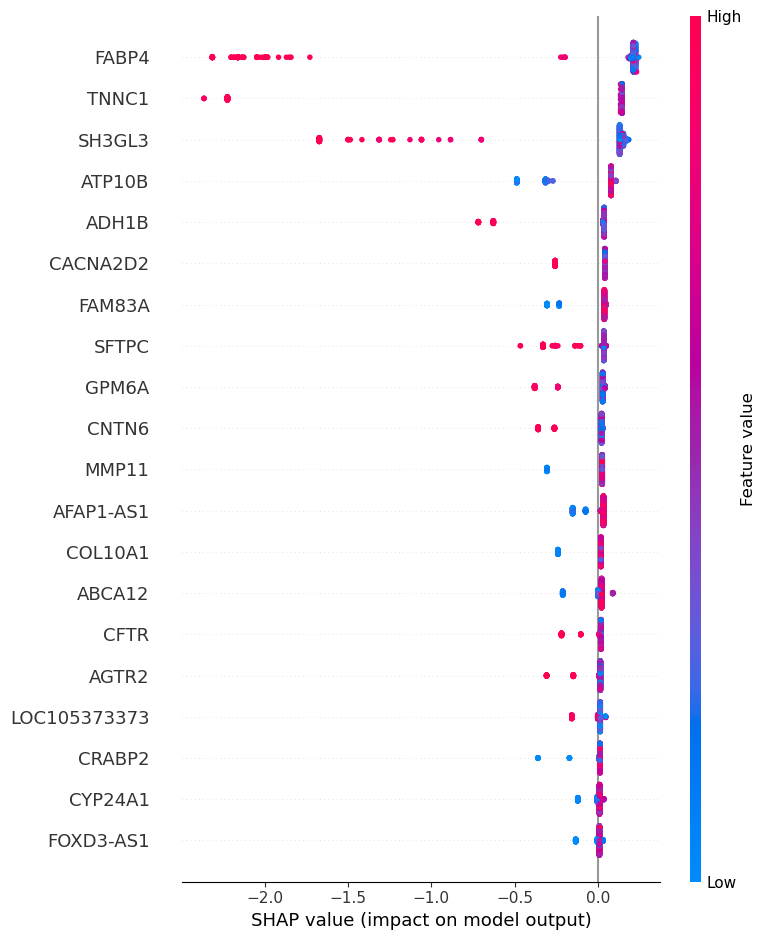

In [34]:
import pandas as pd
import numpy as np
import shap
import joblib
import os
import matplotlib.pyplot as plt

# ✅ Load Expression Matrix (samples × genes) and Metadata
expr_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/data/raw/TCGA_LUAD_expr_HGNC.csv"
meta_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/data/raw/sample_metadata.csv"

# Read data
X_full = pd.read_csv(expr_path, index_col=0).T  # Now rows are samples, columns are genes
meta = pd.read_csv(meta_path)

# Match samples
X_full = X_full.loc[meta['sample_id']]
y = meta['label'].map({'Normal': 0, 'Tumor': 1}).values

# ✅ Select top 1000 most variable genes
top_genes = X_full.var().sort_values(ascending=False).head(1000).index
X_top = X_full[top_genes]

# ✅ Check for saved model
model_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/models/best_model_fold1.pkl"

if not os.path.exists(model_path):
    print("❌ Model not found. Please make sure best_model_fold1.pkl exists.")
else:
    print("✅ Model found. Proceeding...")

    # ✅ Load model
    model = joblib.load(model_path)

    # ✅ SHAP Explainer
    shap.initjs()
    explainer = shap.Explainer(model, X_top)
    shap_values = explainer(X_top)

    # ✅ Plot SHAP summary (top 20 genes)
    shap.summary_plot(shap_values, X_top, feature_names=top_genes, max_display=20)


In [38]:
import shap
import joblib
import pandas as pd
import numpy as np
import os

# === [1] Load Model ===
model_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/models/best_model_fold1.pkl"
model = joblib.load(model_path)

# === [2] Compute SHAP values ===
explainer = shap.Explainer(model)
shap_values = explainer(X_top)

# === [3] Get Mean SHAP Value Per Gene ===
mean_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Gene": X_top.columns,
    "Mean_SHAP": mean_shap
}).sort_values(by="Mean_SHAP", ascending=False)

# === [4] Extract Top N Genes ===
top_n = 100
top_shap_genes = shap_df.head(top_n)["Gene"].tolist()
print("✅ Top 10 SHAP Genes:", top_shap_genes[:10])

# === [5] Save for downstream use ===
output_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/top_SHAP_genes.csv"
shap_df.head(top_n).to_csv(output_path, index=False)
print(f"📁 Top {top_n} SHAP genes saved to: {output_path}")


✅ Top 10 SHAP Genes: ['FABP4', 'SH3GL3', 'TNNC1', 'ADH1B', 'ATP10B', 'GPM6A', 'CNTN6', 'FAM83A', 'MMP11', 'CACNA2D2']
📁 Top 100 SHAP genes saved to: C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/top_SHAP_genes.csv


C:\Users\karth\AppData\Local\Temp\ipykernel_12988\2052799502.py:20: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.tight_layout()
C:\Users\karth\AppData\Local\Temp\ipykernel_12988\2052799502.py:21: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/shap_summary_bar.png", dpi=300)
C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


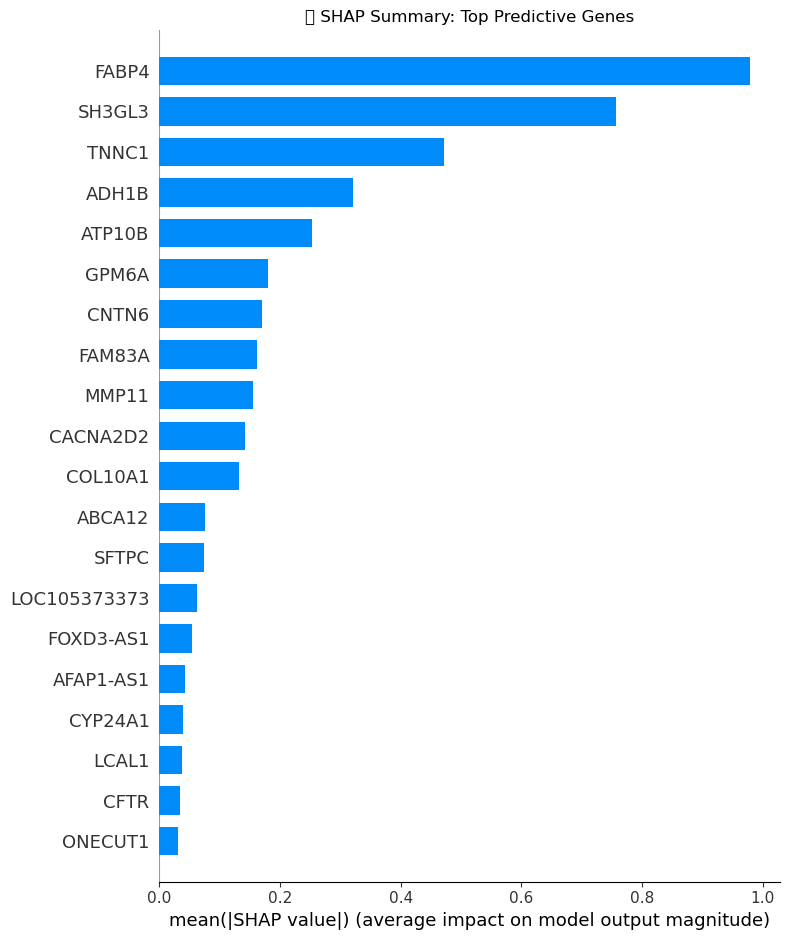

C:\Users\karth\AppData\Local\Temp\ipykernel_12988\2052799502.py:27: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.tight_layout()
C:\Users\karth\AppData\Local\Temp\ipykernel_12988\2052799502.py:28: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/shap_summary_beeswarm.png", dpi=300)
C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


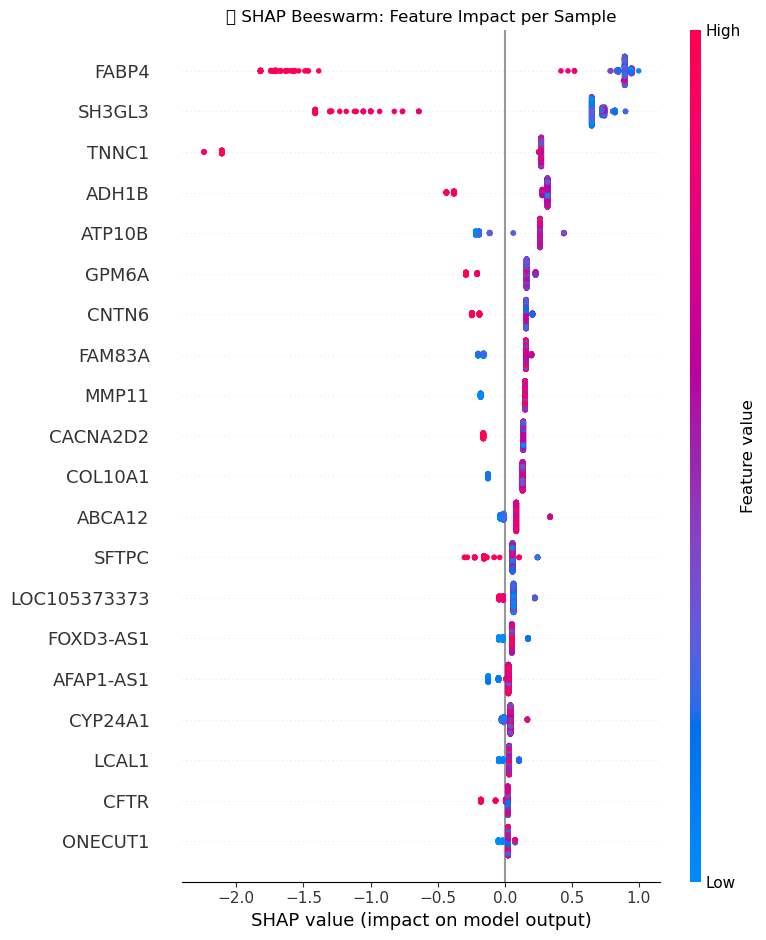

In [40]:
import shap
import matplotlib.pyplot as plt

# ✅ Load the model and data
import joblib
model_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/models/best_model_fold1.pkl"
model = joblib.load(model_path)

# Make sure X_top and gene_names are defined
# X_top is your reduced feature matrix (top 1000 variable genes)
# gene_names = X_top.columns

# ✅ Create SHAP explainer and compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_top)

# ✅ Summary plot (bar)
shap.summary_plot(shap_values, X_top, plot_type="bar", show=False)
plt.title("🔬 SHAP Summary: Top Predictive Genes")
plt.tight_layout()
plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/shap_summary_bar.png", dpi=300)
plt.show()

# ✅ Summary plot (beeswarm)
shap.summary_plot(shap_values, X_top, show=False)
plt.title("🔬 SHAP Beeswarm: Feature Impact per Sample")
plt.tight_layout()
plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/shap_summary_beeswarm.png", dpi=300)
plt.show()


In [44]:
import pandas as pd

# Load and inspect columns
shap_file = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/top_SHAP_genes.csv"
df = pd.read_csv(shap_file)

print("📑 Columns in SHAP file:", df.columns.tolist())
print(df.head())


📑 Columns in SHAP file: ['Gene', 'Mean_SHAP']
     Gene  Mean_SHAP
0   FABP4   0.979414
1  SH3GL3   0.757244
2   TNNC1   0.471699
3   ADH1B   0.320533
4  ATP10B   0.252552


In [48]:
import pandas as pd
import gseapy as gp

# 📁 Load Top SHAP Genes
shap_file = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/top_SHAP_genes.csv"
top_shap_genes = pd.read_csv(shap_file)["Gene"].tolist()

# 📊 Run KEGG Enrichment (Relaxed cutoff to 0.1)
results_dir = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/enrichr_kegg"
enr_kegg = gp.enrichr(
    gene_list=top_shap_genes,
    gene_sets='KEGG_2019_Human',
    organism='Human',
    outdir=results_dir,
    cutoff=0.1  # Relaxed cutoff
)

# 📤 Save all results
out_csv = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/top_SHAP_kegg_enrichment.csv"
enr_kegg.results.to_csv(out_csv, index=False)
print(f"✅ KEGG results saved to: {out_csv}")

# ✅ Show top 10 pathways (if any)
if not enr_kegg.results.empty:
    display(enr_kegg.results.head(10))
else:
    print("⚠️ No KEGG pathways passed the adjusted p-value cutoff.")


✅ KEGG results saved to: C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/top_SHAP_kegg_enrichment.csv


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Fatty acid degradation,3/44,0.001384,0.092745,0,0,14.980387,98.609757,ACADL;ADH1B;ADH7
1,KEGG_2019_Human,Steroid hormone biosynthesis,3/60,0.003376,0.101864,0,0,10.766685,61.273653,SRD5A2;AKR1C3;UGT2B4
2,KEGG_2019_Human,Retinol metabolism,3/67,0.004609,0.101864,0,0,9.585696,51.569321,ADH1B;UGT2B4;ADH7
3,KEGG_2019_Human,Metabolism of xenobiotics by cytochrome P450,3/74,0.006081,0.101864,0,0,8.637578,44.073358,ADH1B;UGT2B4;ADH7
4,KEGG_2019_Human,Chemical carcinogenesis,3/82,0.008073,0.108181,0,0,7.759755,37.395832,ADH1B;UGT2B4;ADH7
5,KEGG_2019_Human,Tyrosine metabolism,2/36,0.013961,0.149749,0,0,11.924370,50.934869,ADH1B;ADH7
6,KEGG_2019_Human,Drug metabolism,3/108,0.016960,0.149749,0,0,5.830633,23.770869,ADH1B;UGT2B4;ADH7
7,KEGG_2019_Human,Fat digestion and absorption,2/41,0.017880,0.149749,0,0,10.392988,41.821870,NPC1L1;PLA2G3
8,KEGG_2019_Human,ABC transporters,2/45,0.021311,0.158648,0,0,9.424300,36.269737,ABCA12;CFTR
9,KEGG_2019_Human,Adrenergic signaling in cardiomyocytes,3/145,0.036257,0.236680,0,0,4.303325,14.274645,TNNC1;CACNA2D2;AGTR2


In [50]:
# GO Biological Process
enr_go = gp.enrichr(
    gene_list=top_shap_genes,
    gene_sets='GO_Biological_Process_2021',
    organism='Human',
    outdir="C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/enrichr_go",
    cutoff=0.1
)
enr_go.results.to_csv("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/top_SHAP_go_enrichment.csv", index=False)


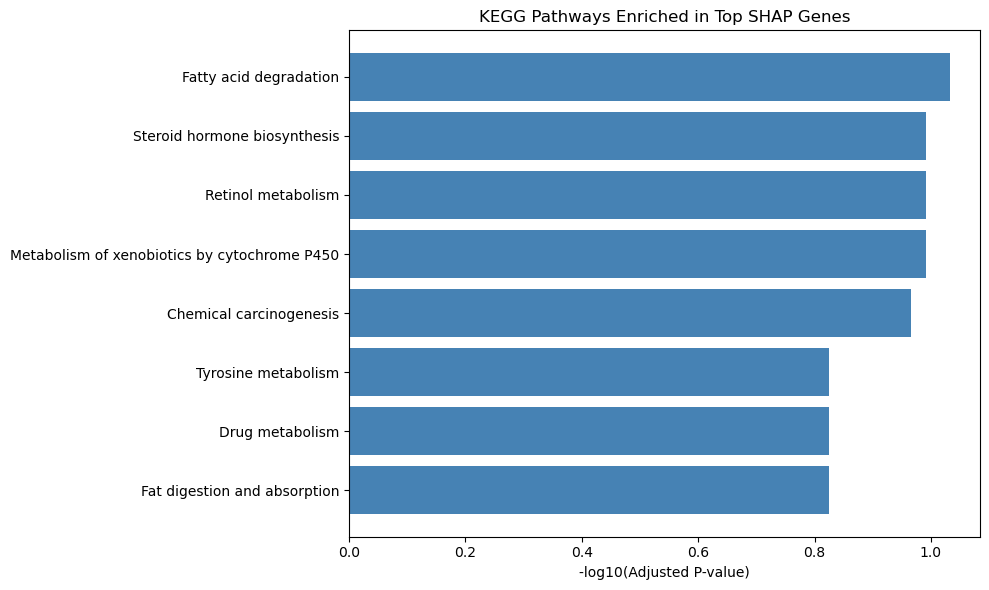

✅ KEGG barplot saved to: C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/SHAP_kegg_barplot.pdf


In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Load enrichment results
kegg_df = pd.read_csv("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/top_SHAP_kegg_enrichment.csv")

# Filter top terms with Adj P < 0.15
top_kegg = kegg_df[kegg_df["Adjusted P-value"] < 0.15].copy()
top_kegg = top_kegg.sort_values("Adjusted P-value").head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_kegg["Term"], -np.log10(top_kegg["Adjusted P-value"]), color='steelblue')
plt.xlabel("-log10(Adjusted P-value)")
plt.title("KEGG Pathways Enriched in Top SHAP Genes")
plt.gca().invert_yaxis()  # Most significant on top
plt.tight_layout()

# Save figure
out_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/SHAP_kegg_barplot.pdf"
plt.savefig(out_path)
plt.show()

print(f"✅ KEGG barplot saved to: {out_path}")


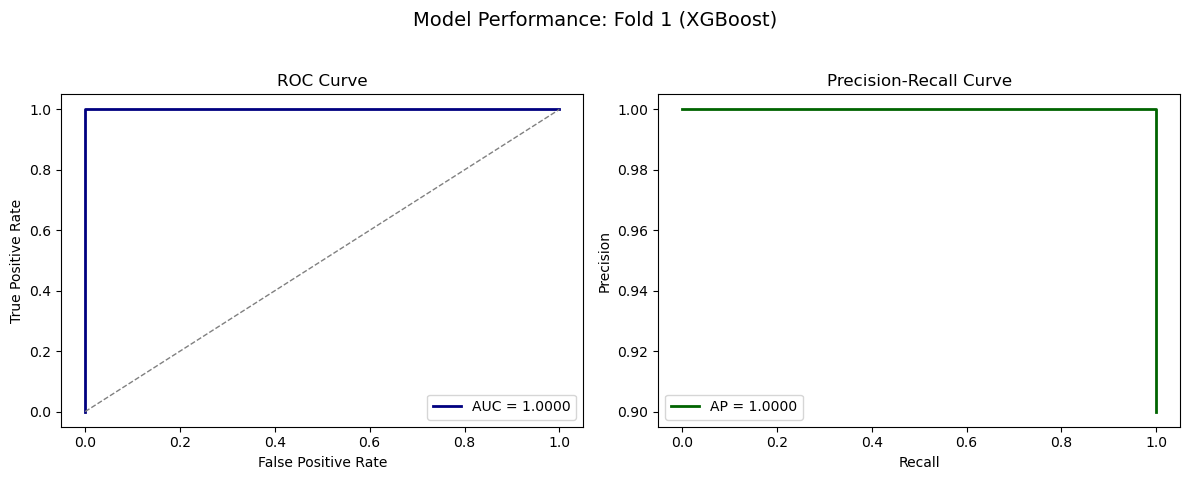

✅ ROC & PR curves saved to: C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/plots/ROC_PR_curves_fold1.pdf


In [54]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

# ----------------------------------------
# 🔁 Load Model and Split Test Data
# ----------------------------------------
model_path = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/models/best_model_fold1.pkl"
model = joblib.load(model_path)

# Train/test split for ROC/PR evaluation
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, stratify=y, random_state=42)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # Class 1 probs

# ----------------------------------------
# 📈 Compute Curves and AUCs
# ----------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

# ----------------------------------------
# 🎨 Plot ROC and PR Curves
# ----------------------------------------
plt.figure(figsize=(12, 5))

# 🔵 ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='navy', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# 🟢 PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkgreen', lw=2, label=f"AP = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")

plt.suptitle("Model Performance: Fold 1 (XGBoost)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 💾 Save
output_file = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/plots/ROC_PR_curves_fold1.pdf"
os.makedirs(os.path.dirname(output_file), exist_ok=True)
plt.savefig(output_file)
plt.show()

print(f"✅ ROC & PR curves saved to: {output_file}")


🔁 Fold 1


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:10:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔁 Fold 2


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:10:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔁 Fold 3


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:10:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔁 Fold 4


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:10:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔁 Fold 5


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:10:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


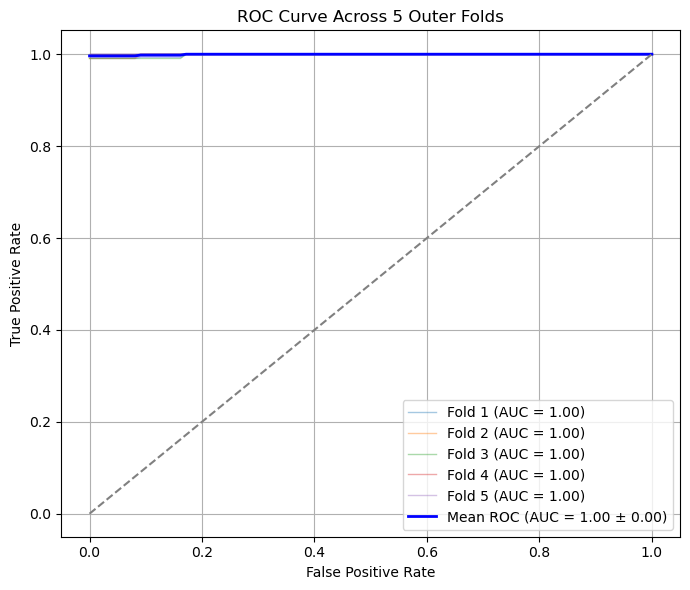

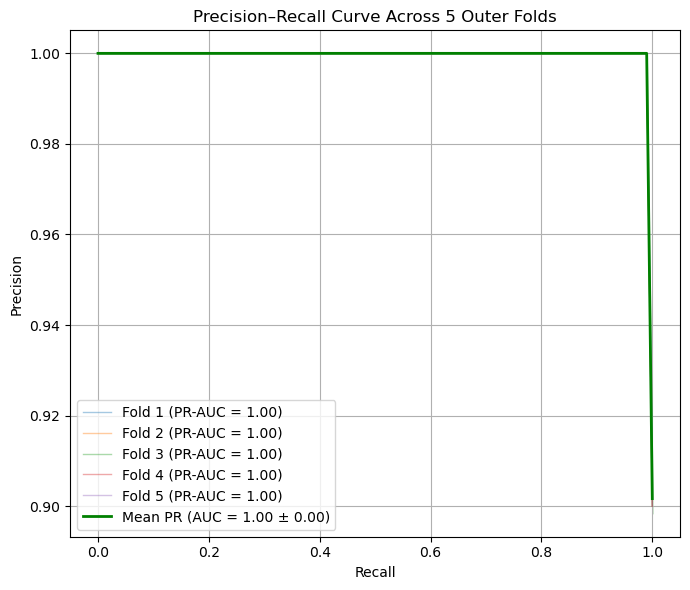

In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from joblib import dump
from sklearn.preprocessing import LabelEncoder

# 🔧 Config
n_splits = 5
random_state = 42
save_dir = "C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/plots"
os.makedirs(save_dir, exist_ok=True)

# ✅ Ensure labels are numeric
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Tumor=1, Normal=0

# 📊 Store results
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

precisions = []
pr_aucs = []
mean_recall = np.linspace(0, 1, 100)

# 📁 Cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for i, (train_idx, test_idx) in enumerate(cv.split(X_top, y_encoded), 1):
    print(f"🔁 Fold {i}")
    
    # ✅ FIX: Use .iloc for row indexing
    X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    # 🚀 Train model
    model = XGBClassifier(use_label_encoder=False, eval_metric="auc", random_state=random_state)
    model.fit(X_train, y_train)

    # 🔍 Predict and evaluate...

    # 🔍 Predict
    probas = model.predict_proba(X_test)[:, 1]

    # 🔹 ROC
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc)

    # 🔸 PR
    precision, recall, _ = precision_recall_curve(y_test, probas)
    pr_auc = average_precision_score(y_test, probas)
    precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
    pr_aucs.append(pr_auc)

# 🎯 Mean ROC
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# 🎯 Mean PR
mean_precision = np.mean(precisions, axis=0)
std_precision = np.std(precisions, axis=0)
mean_pr_auc = np.mean(pr_aucs)
std_pr_auc = np.std(pr_aucs)

# -----------------------------------
# 📈 PLOT 1: ROC Curve
# -----------------------------------
plt.figure(figsize=(7, 6))
for i in range(n_splits):
    plt.plot(mean_fpr, tprs[i], lw=1, alpha=0.4, label=f"Fold {i+1} (AUC = {aucs[i]:.2f})")
plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})", lw=2)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Across 5 Outer Folds")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "ROC_CV_folds.pdf"))
plt.show()

# -----------------------------------
# 📉 PLOT 2: Precision–Recall Curve
# -----------------------------------
plt.figure(figsize=(7, 6))
for i in range(n_splits):
    plt.plot(mean_recall, precisions[i], lw=1, alpha=0.4, label=f"Fold {i+1} (PR-AUC = {pr_aucs[i]:.2f})")
plt.plot(mean_recall, mean_precision, color='g', label=f"Mean PR (AUC = {mean_pr_auc:.2f} ± {std_pr_auc:.2f})", lw=2)
plt.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, color='green', alpha=0.2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Across 5 Outer Folds")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "PR_CV_folds.pdf"))
plt.show()


🔁 Fold 1


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:11:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔁 Fold 2


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:11:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔁 Fold 3


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:11:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔁 Fold 4


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:11:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔁 Fold 5


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:11:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


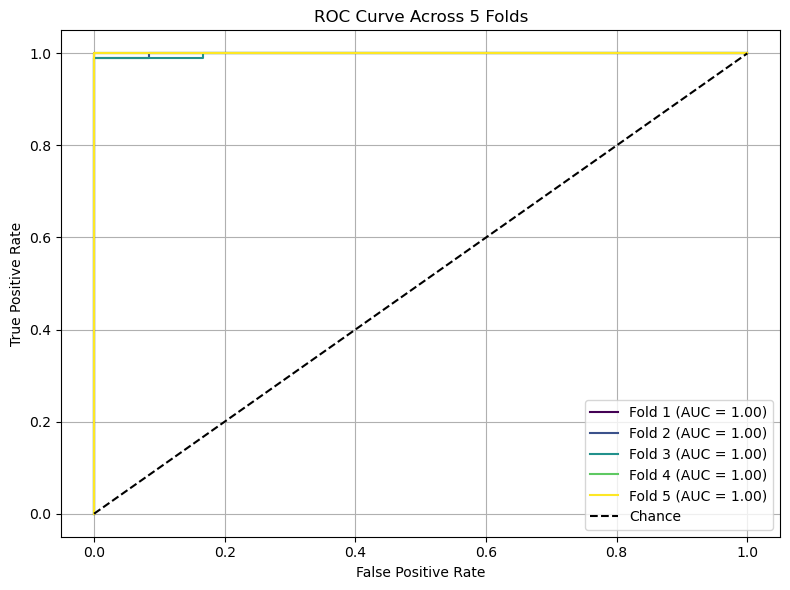

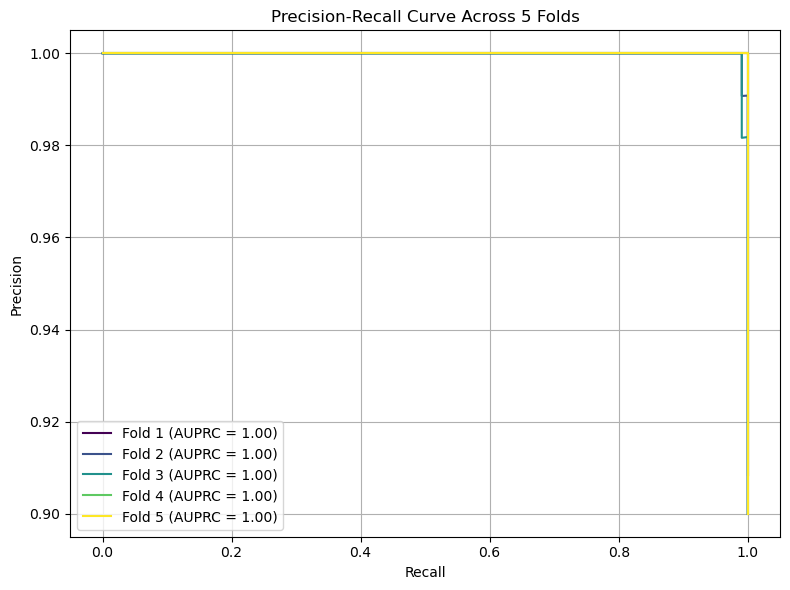

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

# 🎯 Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_curves = []
pr_curves = []

# 🎨 Colors
colors = plt.cm.viridis(np.linspace(0, 1, 5))

# ✅ Run Cross-Validation
for i, (train_idx, test_idx) in enumerate(cv.split(X_top, y_encoded), 1):
    print(f"🔁 Fold {i}")
    
    # Split
    X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    
    # Train
    model = XGBClassifier(use_label_encoder=False, eval_metric="auc", random_state=42)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))
    
    # PR
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    pr_curves.append((precision, recall, pr_auc))

# ----------------------------------------
# 📈 PLOT: ROC Curves
# ----------------------------------------
plt.figure(figsize=(8, 6))
for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
    plt.plot(fpr, tpr, color=colors[i], label=f"Fold {i+1} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Across 5 Folds")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/roc_all_folds.pdf")
plt.show()

# ----------------------------------------
# 📈 PLOT: PR Curves
# ----------------------------------------
plt.figure(figsize=(8, 6))
for i, (precision, recall, pr_auc) in enumerate(pr_curves):
    plt.plot(recall, precision, color=colors[i], label=f"Fold {i+1} (AUPRC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Across 5 Folds")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/pr_all_folds.pdf")
plt.show()


C:\Users\karth\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:12:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\karth\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\karth\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\karth\AppData\Local\Temp\ipykernel_12988\1691011852.py:45: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/SHAP_clustermap.pdf")
C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N

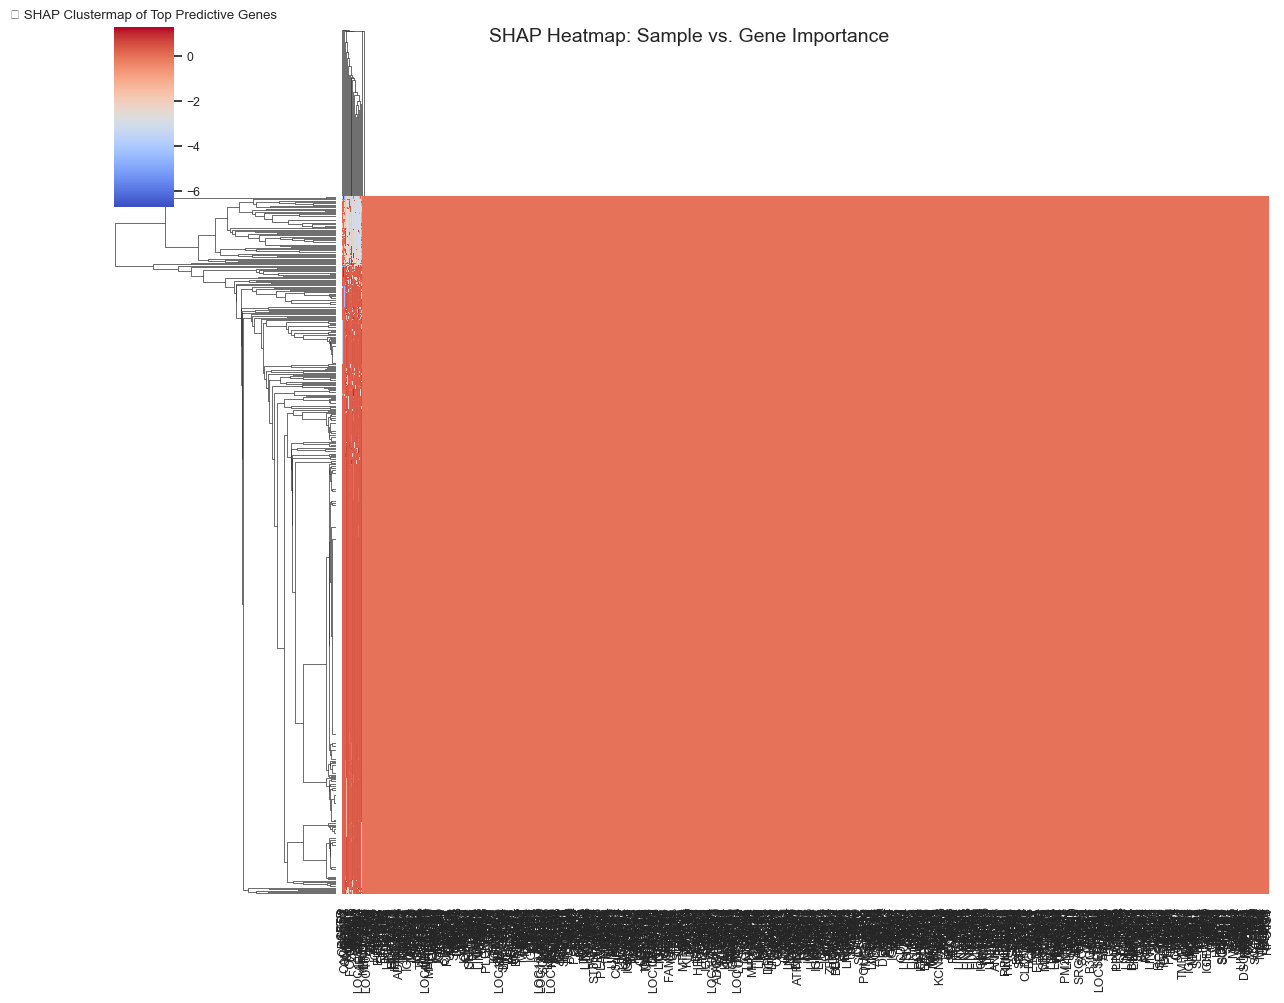

In [62]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------
# 🎯 Step 1: Prepare data and model
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_top, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric="auc", random_state=42)
model.fit(X_train, y_train)

# -------------------------------------------------
# 🔍 Step 2: Compute SHAP values
# -------------------------------------------------
explainer = shap.Explainer(model, X_top)
shap_values = explainer(X_top)

# -------------------------------------------------
# 🔥 Step 3: Generate clustered SHAP heatmap
# -------------------------------------------------
# Convert to numpy array
shap_matrix = shap_values.values

# Scale for better heatmap contrast (optional)
scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_matrix)

# Use seaborn clustermap
sns.set(font_scale=0.8)
g = sns.clustermap(
    shap_scaled,
    figsize=(12, 10),
    col_cluster=True,
    row_cluster=True,
    cmap="coolwarm",
    xticklabels=X_top.columns,
    yticklabels=False
)

plt.title("🔬 SHAP Clustermap of Top Predictive Genes")
g.fig.suptitle("SHAP Heatmap: Sample vs. Gene Importance", fontsize=14)
plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/SHAP_clustermap.pdf")
plt.show()


C:\Users\karth\AppData\Local\Temp\ipykernel_12988\2855999608.py:41: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/SHAP_clustermap.pdf", bbox_inches='tight')
C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


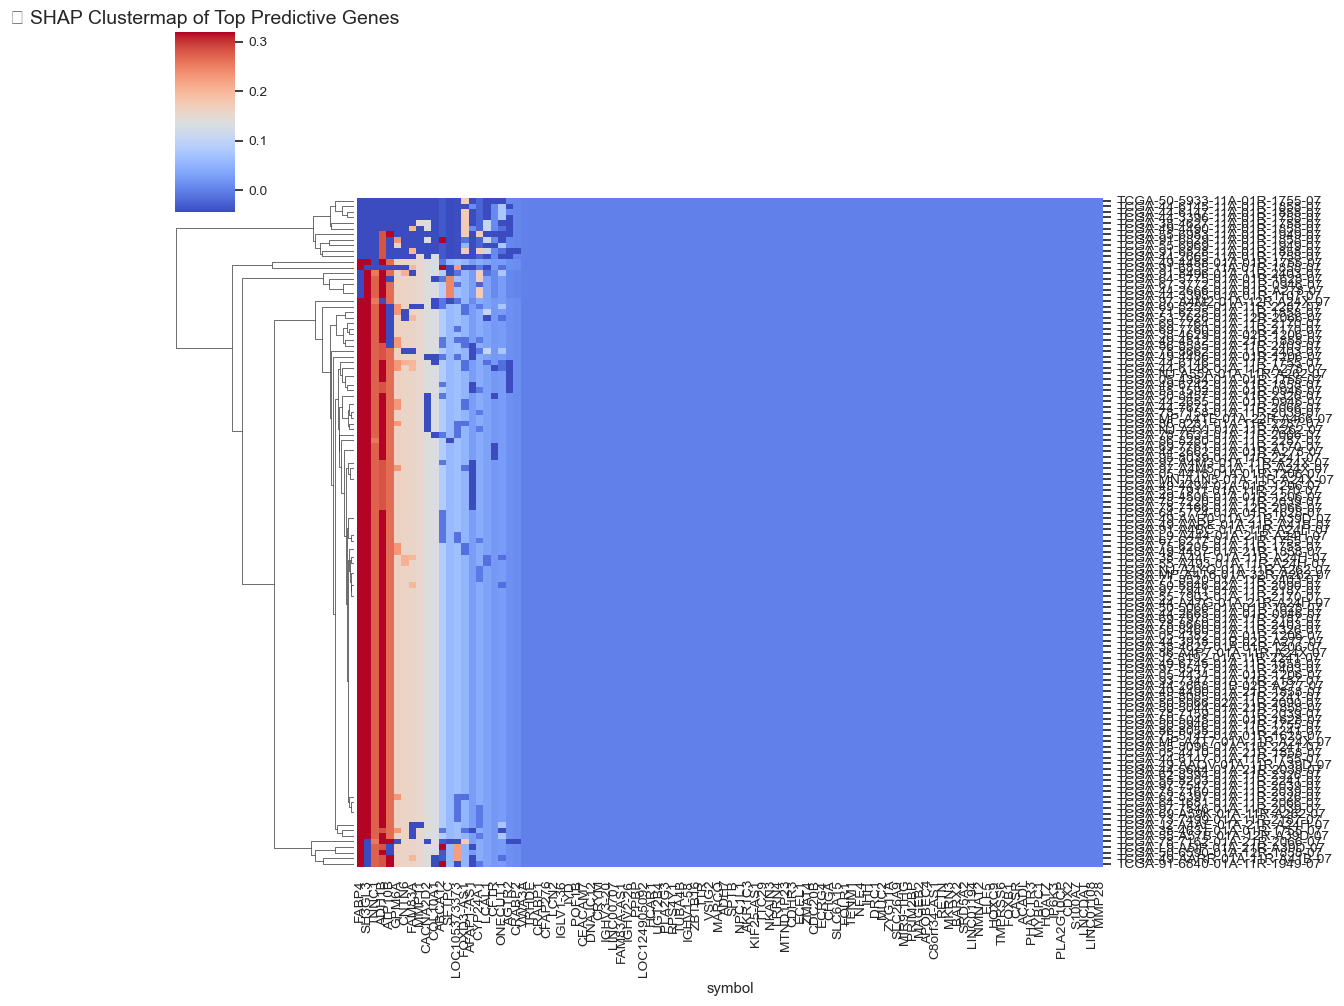

In [70]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

# ✅ Set font for plot compatibility
matplotlib.rcParams['font.family'] = 'Arial'

# ✅ Load your trained model and data
# Assume:
# model → trained XGBoost model
# X_test → full test set with all features used during training
# top_genes → list of top N gene names to highlight (e.g., SHAP-ranked)
# Ensure X_test has same features and order as training data

# ✅ Step 1: Create SHAP explainer
explainer = shap.Explainer(model)

# ✅ Step 2: Compute SHAP values on the full input (not subset!)
shap_values = explainer(X_test)

# ✅ Step 3: Convert to DataFrame and subset top genes
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns, index=X_test.index)
shap_top_df = shap_df[top_genes]  # Top SHAP genes (e.g., top 50)

# ✅ Step 4: Plot heatmap with clustermap
sns.set(font_scale=0.9)
g = sns.clustermap(
    shap_top_df,
    cmap='coolwarm',
    figsize=(12, 10),
    col_cluster=False,  # Cluster samples only
    yticklabels=True,
    xticklabels=True,
    robust=True
)

# ✅ Final title and save
plt.title("🔬 SHAP Clustermap of Top Predictive Genes", fontsize=14)
plt.savefig("C:/Users/karth/OneDrive/Documents/LUAD_Biomarker_Project/results/SHAP_clustermap.pdf", bbox_inches='tight')
plt.show()


In [3]:
try:
    snakemake
except NameError:
    # Manual mode: define file paths manually
    class Snakemake:
        input = {
            "expr": "data/TCGA_LUAD_TPM.csv",
            "clin": "data/clinical.csv"
        }
        output = [
            "results/ML/shap_summary_plot.png",
            "results/ML/top_predictors.csv"
        ]

    snakemake = Snakemake()


In [1]:
import pandas as pd

# Define file paths
up_path = "E:/DOCUMENTS/LUAD_Biomarker_Project/drug_repurposing/up_genes.txt"
down_path = "E:/DOCUMENTS/LUAD_Biomarker_Project/drug_repurposing/down_genes.txt"

# Load gene lists
with open(up_path) as f:
    up_genes = [line.strip() for line in f.readlines()]
with open(down_path) as f:
    down_genes = [line.strip() for line in f.readlines()]

print(f"🔼 Upregulated genes: {len(up_genes)}")
print(f"🔽 Downregulated genes: {len(down_genes)}")

# Safety check
assert len(up_genes) >= 10 and len(down_genes) >= 10, "At least 10 genes required in each list."


🔼 Upregulated genes: 135
🔽 Downregulated genes: 166


🔼 Upregulated genes: 135
🔽 Downregulated genes: 166
✅ Submitted to Enrichr (up: 98260452, down: 98260453)
✅ Top drug hits saved.


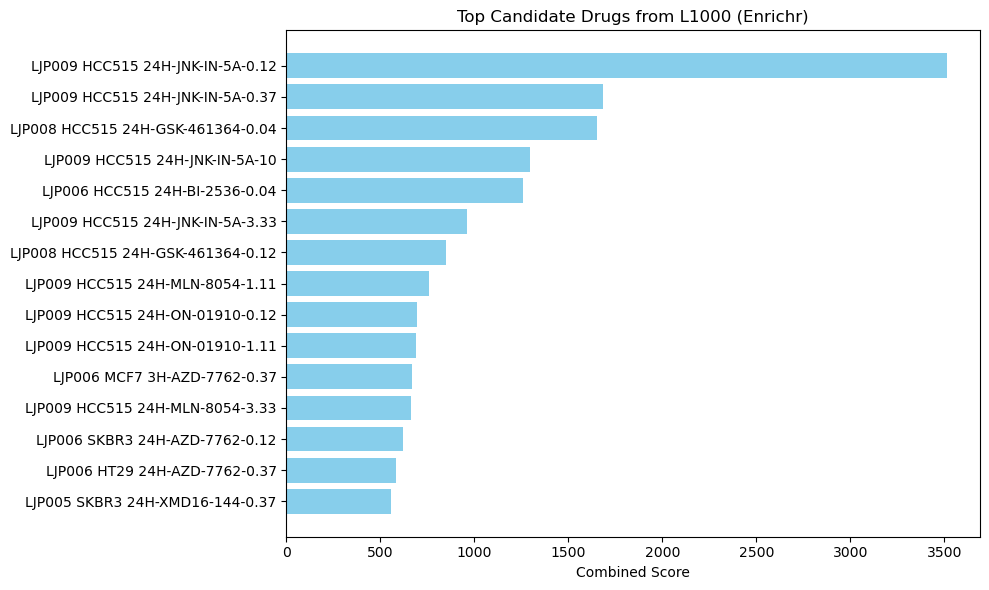

In [9]:
# Cell 1: Imports and setup
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import time

ENRICHR_ADDLIST_URL = "https://maayanlab.cloud/Enrichr/addList"
ENRICHR_ENRICH_URL = "https://maayanlab.cloud/Enrichr/enrich"

headers = {'Content-Type': 'application/x-www-form-urlencoded'}

# Cell 2: Load gene signatures
up_path = r"E:\DOCUMENTS\LUAD_Biomarker_Project\drug_repurposing\up_genes.txt"
down_path = r"E:\DOCUMENTS\LUAD_Biomarker_Project\drug_repurposing\down_genes.txt"

with open(up_path, "r") as f:
    up_genes = f.read().strip().splitlines()

with open(down_path, "r") as f:
    down_genes = f.read().strip().splitlines()

print(f"🔼 Upregulated genes: {len(up_genes)}")
print(f"🔽 Downregulated genes: {len(down_genes)}")

# Cell 3: Submit to Enrichr
def submit_to_enrichr(genes, description="DEG Signature"):
    payload = {
        'list': "\n".join(genes),
        'description': description
    }
    response = requests.post(ENRICHR_ADDLIST_URL, files=payload)
    if not response.ok:
        raise Exception("❌ Enrichr addList failed.")
    return response.json()['userListId']

up_id = submit_to_enrichr(up_genes, "LUAD_Up")
down_id = submit_to_enrichr(down_genes, "LUAD_Down")
print(f"✅ Submitted to Enrichr (up: {up_id}, down: {down_id})")

# Cell 4: Run enrichment on LINCS up/down
def get_enrichment(user_list_id, library):
    response = requests.get(f"{ENRICHR_ENRICH_URL}?userListId={user_list_id}&backgroundType={library}")
    if not response.ok:
        raise Exception("❌ Enrichment failed.")
    return pd.DataFrame(response.json()[library], columns=[
        'Rank', 'Term', 'P-value', 'Z-score', 'Combined Score', 'Genes', 'Adjusted P-value', 'Old P-value', 'Old Adjusted P-value'])

# Get drug reversal profiles
df_up = get_enrichment(up_id, "LINCS_L1000_Chem_Pert_up")
df_down = get_enrichment(down_id, "LINCS_L1000_Chem_Pert_down")

# Cell 5: Combine and rank top drugs
df_up["Source"] = "Up"
df_down["Source"] = "Down"
combined = pd.concat([df_up, df_down])

# Select drugs with strong reversal potential (combined score > 20, adjusted p < 0.05)
filtered = combined[(combined["Combined Score"] > 20) & (combined["Adjusted P-value"] < 0.05)]
top_drugs = filtered.sort_values(by="Combined Score", ascending=False).head(15)

# Save
top_drugs.to_csv("E:/DOCUMENTS/LUAD_Biomarker_Project/drug_repurposing/top_L1000_drugs.csv", index=False)
print("✅ Top drug hits saved.")

# Cell 6: Plot
plt.figure(figsize=(10, 6))
plt.barh(top_drugs["Term"], top_drugs["Combined Score"], color='skyblue')
plt.xlabel("Combined Score")
plt.title("Top Candidate Drugs from L1000 (Enrichr)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# === File paths ===
drug_hits_file = r"E:\DOCUMENTS\LUAD_Biomarker_Project\drug_repurposing\top_L1000_drugs.csv"
trial_info_file = r"E:\DOCUMENTS\LUAD_Biomarker_Project\drug_repurposing\drug_trial_annotations.csv"
output_file = r"E:\DOCUMENTS\LUAD_Biomarker_Project\drug_repurposing\annotated_drug_hits.csv"

# === Load data ===
drug_hits = pd.read_csv(drug_hits_file)
trial_info = pd.read_csv(trial_info_file)

# === Preprocess ===
# Standardize drug names
drug_hits['Drug'] = drug_hits['Term'].str.upper().str.strip()
trial_info['Drug'] = trial_info['Drug'].str.upper().str.strip()

# === Merge clinical phase info ===
annotated_hits = pd.merge(drug_hits, trial_info, on='Drug', how='left')

# === Save result ===
annotated_hits.to_csv(output_file, index=False)

# === View top results with phase info ===
annotated_hits[['Drug', 'Phase', 'Condition', 'Combined Score']].head(10)


,Drug,Phase,Condition,Combined Score
0,LJP009 HCC515 24H-JNK-IN-5A-0.12,NaN,NaN,3513.565612
1,LJP009 HCC515 24H-JNK-IN-5A-0.37,NaN,NaN,1684.156644
2,LJP008 HCC515 24H-GSK-461364-0.04,NaN,NaN,1653.461420
3,LJP009 HCC515 24H-JNK-IN-5A-10,NaN,NaN,1295.227723
4,LJP006 HCC515 24H-BI-2536-0.04,NaN,NaN,1258.324390
5,LJP009 HCC515 24H-JNK-IN-5A-3.33,NaN,NaN,961.284461
6,LJP008 HCC515 24H-GSK-461364-0.12,NaN,NaN,851.025398
7,LJP009 HCC515 24H-MLN-8054-1.11,NaN,NaN,758.636039
8,LJP009 HCC515 24H-ON-01910-0.12,NaN,NaN,692.993268
9,LJP009 HCC515 24H-ON-01910-1.11,NaN,NaN,688.457345


In [25]:
pip install cmapPy


   ---------------------------------------- 0.0/150.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/150.2 kB ? eta -:--:--
   ------- ------------------------------- 30.7/150.2 kB 640.0 kB/s eta 0:00:01
   --------------- ----------------------- 61.4/150.2 kB 648.1 kB/s eta 0:00:01
   -------------------------------------- 150.2/150.2 kB 992.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [27]:
from cmapPy.pandasGEXpress.parse import parse
import pandas as pd

# Load the NCS matrix
gct_file = r"E:/DOCUMENTS/LUAD_Biomarker_Project/drug_repurposing/my_analysis.sig_queryl1k_tool.688f39a60f015300129053d0/ncs.gct"
ncs_data = parse(gct_file)

# Access data as a DataFrame
ncs_df = ncs_data.data_df

# Inspect
print("🔬 NCS matrix shape:", ncs_df.shape)
print(ncs_df.head())

# Filter: strong negative connectivity (score < -0.9)
strong_hits = ncs_df[ncs_df.lt(-0.9).any(axis=1)]
print("Strong reversal drugs:", strong_hits.shape[0])


C:\Users\karth\anaconda3\Lib\site-packages\cmapPy\pandasGEXpress\parse_gct.py:251: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  row_metadata = row_metadata.apply(lambda x: pd.to_numeric(x, errors="ignore"))
C:\Users\karth\anaconda3\Lib\site-packages\cmapPy\pandasGEXpress\parse_gct.py:277: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  col_metadata = col_metadata.apply(lambda x: pd.to_numeric(x, errors="ignore"))


🔬 NCS matrix shape: (1165466, 1)
cid                                                    TAG
rid                                                       
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.3125:24  0.0000
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.3125:3   0.0000
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.625:24   1.0023
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.625:3    0.0000
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:1.25:24    0.7856
✅ Strong reversal drugs: 207116


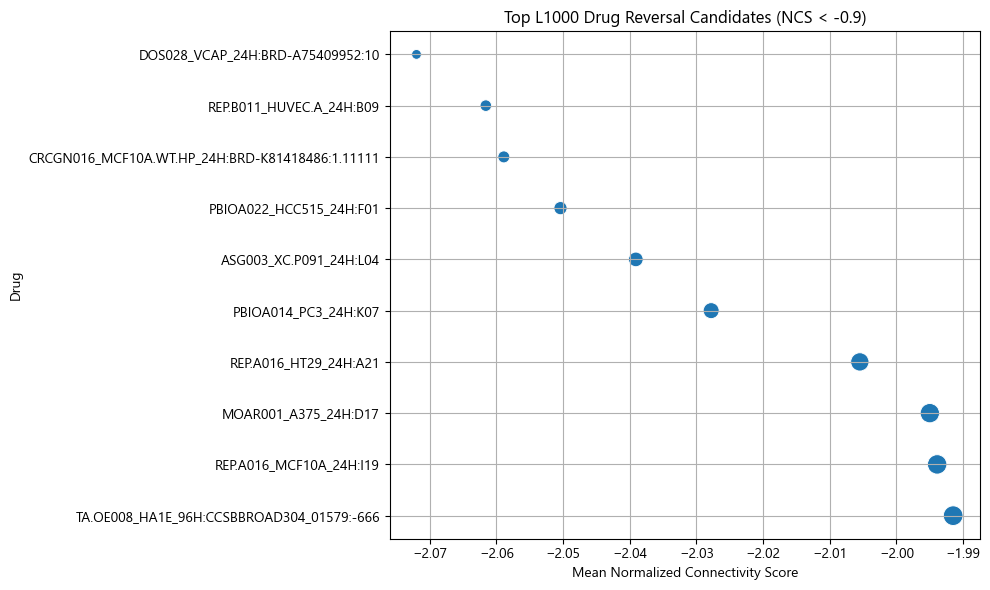

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

top_drugs = strong_hits.mean(axis=1).sort_values().head(10).reset_index()
top_drugs.columns = ['Drug', 'Mean NCS']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=top_drugs,
    x="Mean NCS",
    y="Drug",
    size="Mean NCS",
    legend=False,
    sizes=(50, 200)  # Adjust dot sizes for better visibility
)
plt.title("Top L1000 Drug Reversal Candidates (NCS < -0.9)")
plt.xlabel("Mean Normalized Connectivity Score")
plt.grid(True)
plt.tight_layout()

# Save the plot (before plt.show()!)
plt.savefig(
    "top_drug_reversal_candidates.png",  # Filename (supports .png, .jpg, .pdf, .svg)
    dpi=300,           # High resolution (optional)
    bbox_inches='tight' # Prevents cropping
)

plt.show()  # Display the plot

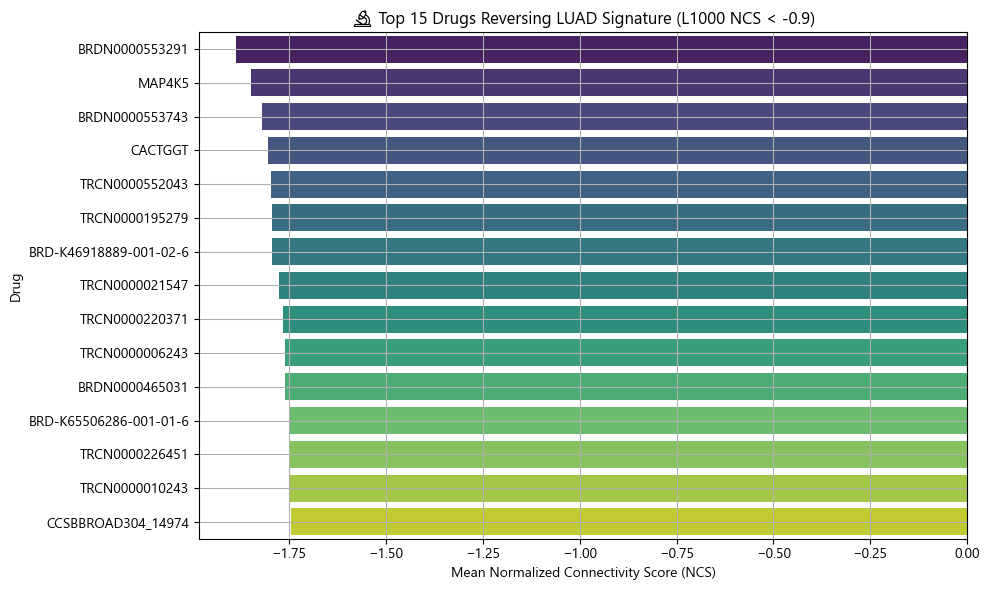

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a font that supports emojis (Windows)
plt.rcParams['font.family'] = 'Segoe UI Emoji'  # or another emoji-supporting font

top_plot = summary.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_plot, y="Drug", x="Mean_NCS", hue="Drug", palette="viridis", legend=False)
plt.title("🔬 Top 15 Drugs Reversing LUAD Signature (L1000 NCS < -0.9)")
plt.xlabel("Mean Normalized Connectivity Score (NCS)")
plt.ylabel("Drug")
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig("top_drugs_reversing_luad.png", dpi=300, bbox_inches='tight')

plt.show()